In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

cudnn.benchmark = True
plt.ion()   # interactive mode
# Creates a runs/baseline_resnet18 folder
writer = SummaryWriter("TensorBoard/runs/baseline_resnet18")

## Load Data

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = '../Datasets/Kaggle/flower-data'
# A map with keys "train" and "val" and values being images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# A map with keys "train" and "val" and values being DataLoaders. A DataLoader is an iterable. 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize data

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

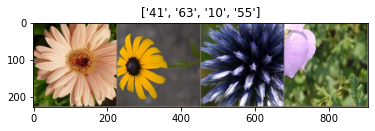

In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch for the visualization purposes
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Test

In [6]:
inputs, classes = next(iter(dataloaders["train"]))
print(classes)

tensor([77, 82,  8, 43])


## Train the model

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over batches
            batch_index = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                # Move the data to the proper device (GPU or CPU)
                inputs = inputs.to(device) 
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                batch_loss = loss.item() * inputs.size(0)
                running_loss += batch_loss
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                
                # Write the loss and accuracy to TensorBoard
                writer.add_scalar('Loss/' + phase, batch_loss, epoch * len(dataloaders[phase]) + batch_index)
                writer.add_scalar('Accuracy/' + phase, batch_corrects / inputs.size(0), epoch * len(dataloaders[phase]) + batch_index)
                
                batch_index += 1
            # lr_scheduler provides several methods to adjust the learning rate based on the number of epochs
            if phase == 'train':
                scheduler.step()
                
            # Loss and accuracy of the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    writer.flush()
    return model

## Visualize the model predictions

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetune the ResNet18

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

num_classes = 102
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes) 

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


100%|█████████████| 1638/1638 [01:37<00:00, 16.76it/s]


train Loss: 1.2454 Acc: 0.6923


100%|███████████████| 205/205 [00:05<00:00, 37.71it/s]


val Loss: 0.3301 Acc: 0.9132

Epoch 1/9
----------


100%|█████████████| 1638/1638 [01:37<00:00, 16.76it/s]


train Loss: 0.8918 Acc: 0.7795


100%|███████████████| 205/205 [00:05<00:00, 40.50it/s]


val Loss: 0.2986 Acc: 0.9254

Epoch 2/9
----------


100%|█████████████| 1638/1638 [01:38<00:00, 16.69it/s]


train Loss: 0.8044 Acc: 0.7970


100%|███████████████| 205/205 [00:05<00:00, 40.64it/s]


val Loss: 0.2677 Acc: 0.9352

Epoch 3/9
----------


100%|█████████████| 1638/1638 [01:37<00:00, 16.72it/s]


train Loss: 0.6836 Acc: 0.8266


100%|███████████████| 205/205 [00:05<00:00, 40.28it/s]


val Loss: 0.2619 Acc: 0.9377

Epoch 4/9
----------


100%|█████████████| 1638/1638 [01:38<00:00, 16.63it/s]


train Loss: 0.6544 Acc: 0.8289


100%|███████████████| 205/205 [00:05<00:00, 35.53it/s]


val Loss: 0.2490 Acc: 0.9499

Epoch 5/9
----------


100%|█████████████| 1638/1638 [01:38<00:00, 16.61it/s]


train Loss: 0.6129 Acc: 0.8417


100%|███████████████| 205/205 [00:05<00:00, 40.40it/s]


val Loss: 0.2100 Acc: 0.9511

Epoch 6/9
----------


100%|█████████████| 1638/1638 [01:38<00:00, 16.68it/s]


train Loss: 0.4518 Acc: 0.8884


100%|███████████████| 205/205 [00:05<00:00, 40.44it/s]


val Loss: 0.1632 Acc: 0.9707

Epoch 7/9
----------


100%|█████████████| 1638/1638 [01:38<00:00, 16.60it/s]


train Loss: 0.3617 Acc: 0.9142


100%|███████████████| 205/205 [00:05<00:00, 40.01it/s]


val Loss: 0.1382 Acc: 0.9743

Epoch 8/9
----------


100%|█████████████| 1638/1638 [01:39<00:00, 16.50it/s]


train Loss: 0.3348 Acc: 0.9216


100%|███████████████| 205/205 [00:05<00:00, 39.97it/s]


val Loss: 0.1443 Acc: 0.9731

Epoch 9/9
----------


100%|█████████████| 1638/1638 [01:39<00:00, 16.51it/s]


train Loss: 0.3286 Acc: 0.9199


100%|███████████████| 205/205 [00:05<00:00, 40.31it/s]

val Loss: 0.1387 Acc: 0.9694

Training complete in 17m 16s
Best val Acc: 0.974328


In [ ]:
visualize_model(model_ft)

## Save Model

In [ ]:
torch.save(model_ft.state_dict(), "saved-models/baseline_resnet18_10epochs.pth")

## Close the TensorBoard summary writer

In [ ]:
writer.close()